In [1]:
!pip install pandas geopandas osmnx matplotlib numpy shapely contextily


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install geopandas


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install contextily


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.patches import Patch

# 1. Load data bangunan dari CSV
building_data = pd.read_csv('Koordinat google earth.csv')

# 2. Konversi ke GeoDataFrame dengan CRS EPSG:4326
geometry = [Point(xy) for xy in zip(building_data['Longtitude'], building_data['Latitude'])]
building_points = gpd.GeoDataFrame(building_data, geometry=geometry, crs="EPSG:4326")

In [6]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box

# Titik tengah kota Purwokerto
place_name = "Purwokerto, Jawa Tengah, Indonesia"
point = ox.geocode(place_name)
print(f"Koordinat pusat: {point}")

# Radius area (meter)
radius = 7000

# Ambil bangunan dalam radius dari titik tersebut
tags = {"building": True}
all_buildings = ox.features_from_point(point, tags=tags, dist=radius)

# Buat boundary lingkaran untuk visualisasi dan analisis
from shapely.geometry import Point
from geopandas import GeoDataFrame
from pyproj import CRS

circle = Point(point).buffer(radius / 111320)  # ~1 derajat ≈ 111.32 km
boundary = GeoDataFrame(geometry=[circle], crs="EPSG:4326")

print(f"Jumlah bangunan yang ditemukan: {len(all_buildings)}")


Koordinat pusat: (-7.4194647, 109.2218425)
Jumlah bangunan yang ditemukan: 170766


In [7]:


# 1. Ambil koordinat pusat kota Purwokerto
place_name = "Purwokerto, Jawa Tengah, Indonesia"
point = ox.geocode(place_name)
print(f"Koordinat pusat Purwokerto: {point}")

# 2. Ambil bangunan dari OSM dalam radius 7000 meter
radius = 7000  # meter
tags = {"building": True}
all_buildings = ox.features_from_point(point, tags=tags, dist=radius)

print(f"Jumlah bangunan ditemukan: {len(all_buildings)}")

# 3. Ubah ke Web Mercator (EPSG:3857) untuk ditampilkan di contextily
all_buildings = all_buildings.to_crs(epsg=3857)


Koordinat pusat Purwokerto: (-7.4194647, 109.2218425)
Jumlah bangunan ditemukan: 170766


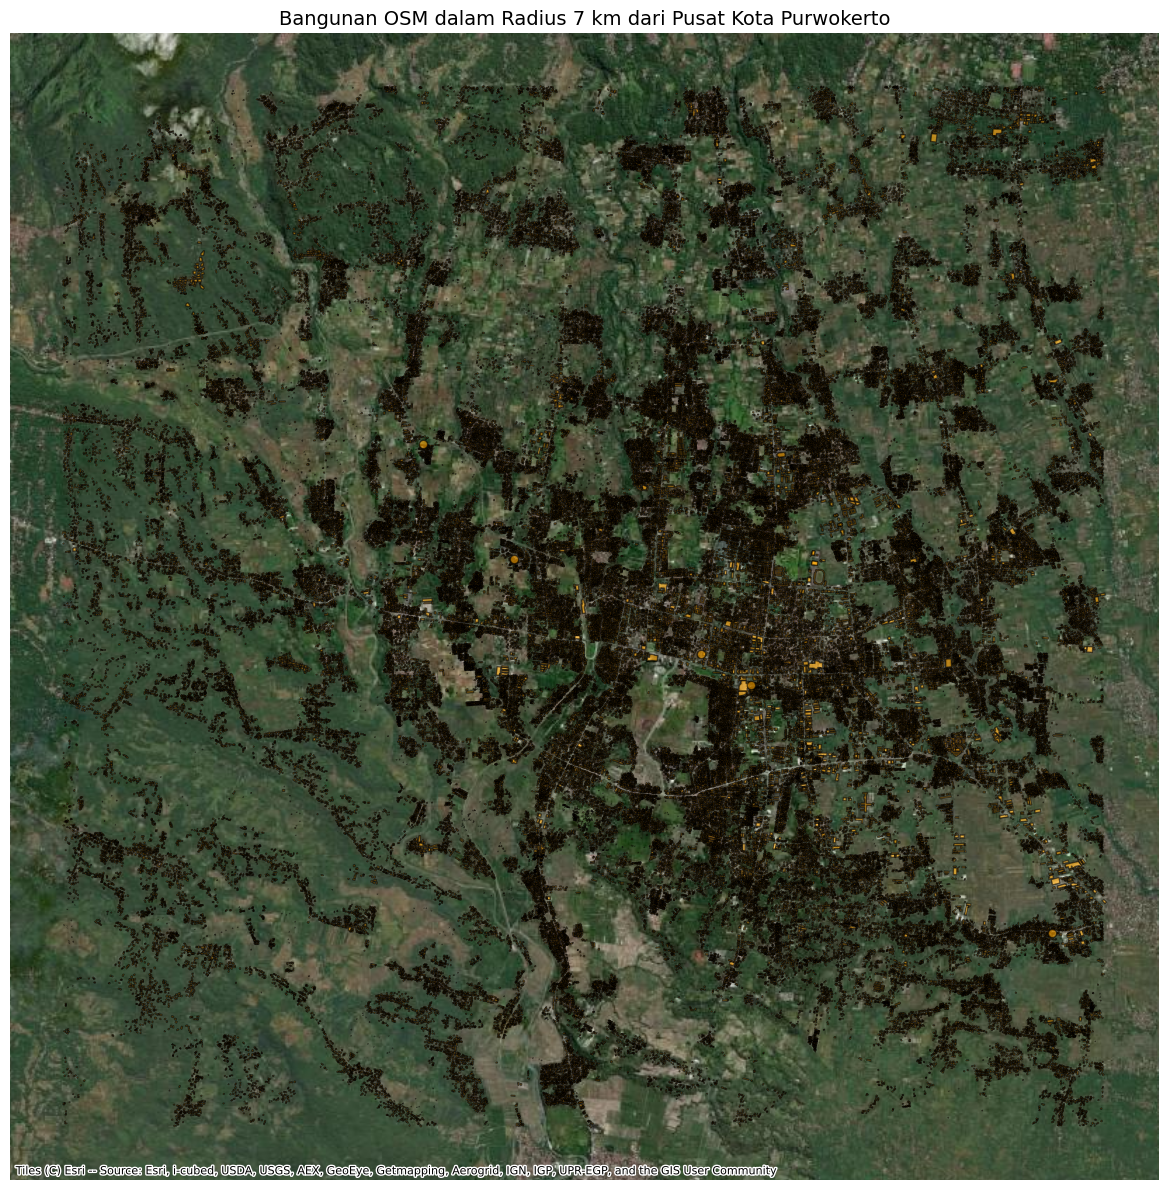

In [8]:
# 4. Buat plot
fig, ax = plt.subplots(figsize=(12, 12))
all_buildings.plot(ax=ax, color="orange", edgecolor="black", alpha=0.6)

# Tambahkan peta dasar
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

ax.set_title("Bangunan OSM dalam Radius 7 km dari Pusat Kota Purwokerto", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
from shapely.geometry import Point

# Contoh: titik koordinat dari CSV Google Earth
geometry = [Point(xy) for xy in zip(building_data['Longtitude'], building_data['Latitude'])]
building_points = gpd.GeoDataFrame(building_data, geometry=geometry, crs="EPSG:4326")


In [10]:
building_data.head()

Lokasi  Latitude  Longtitude
0                           Abata -7.429040  109.243283
1                     Adi Permana -7.437989  109.244036
2  alet mas plastik - studio beau -7.434837  109.290399
3         Alfamart (deket telkom) -7.434521  109.248707
4          Alfamart Karanglewas 1 -7.419420  109.200428

In [11]:
building_points = building_points.to_crs(epsg=3857)
all_buildings = all_buildings.to_crs(epsg=3857)


In [12]:
def classify_density(density):
    if density < 0.3:
        return "Rendah"
    elif density < 0.6:
        return "Sedang"
    else:
        return "Tinggi"

radius = 200  # meter
results = []

for idx, row in building_points.iterrows():
    buffer = row.geometry.buffer(radius)
    within_buffer = all_buildings[all_buildings.geometry.intersects(buffer)]

    building_area = within_buffer.geometry.area.sum()
    buffer_area = buffer.area
    density = building_area / buffer_area if buffer_area > 0 else 0

    results.append({
        "nama_bangunan": row['Lokasi'],
        "geometry": row.geometry,
        "building_count": len(within_buffer),
        "building_area_m2": building_area,
        "buffer_area_m2": buffer_area,
        "building_density": density,
        "kategori_kerapatan": classify_density(density)
    })


In [13]:
results_gdf = gpd.GeoDataFrame(results, crs=building_points.crs)
results_gdf.head()


nama_bangunan                          geometry  \
0                           Abata  POINT (12160906.671 -829324.029)   
1                     Adi Permana  POINT (12160990.417 -830328.643)   
2  alet mas plastik - studio beau  POINT (12166151.603 -829974.797)   
3         Alfamart (deket telkom)  POINT (12161510.435 -829939.271)   
4          Alfamart Karanglewas 1   POINT (12156136.09 -828243.985)   

   building_count  building_area_m2  buffer_area_m2  building_density  \
0             308      77048.484342   125461.939622          0.614118   
1             112      24856.430690   125461.939622          0.198119   
2               0          0.000000   125461.939622          0.000000   
3             170      51275.392588   125461.939622          0.408693   
4             204      29104.133907   125461.939622          0.231976   

  kategori_kerapatan  
0             Tinggi  
1             Rendah  
2             Rendah  
3             Sedang  
4             Rendah

c:\Users\didik\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


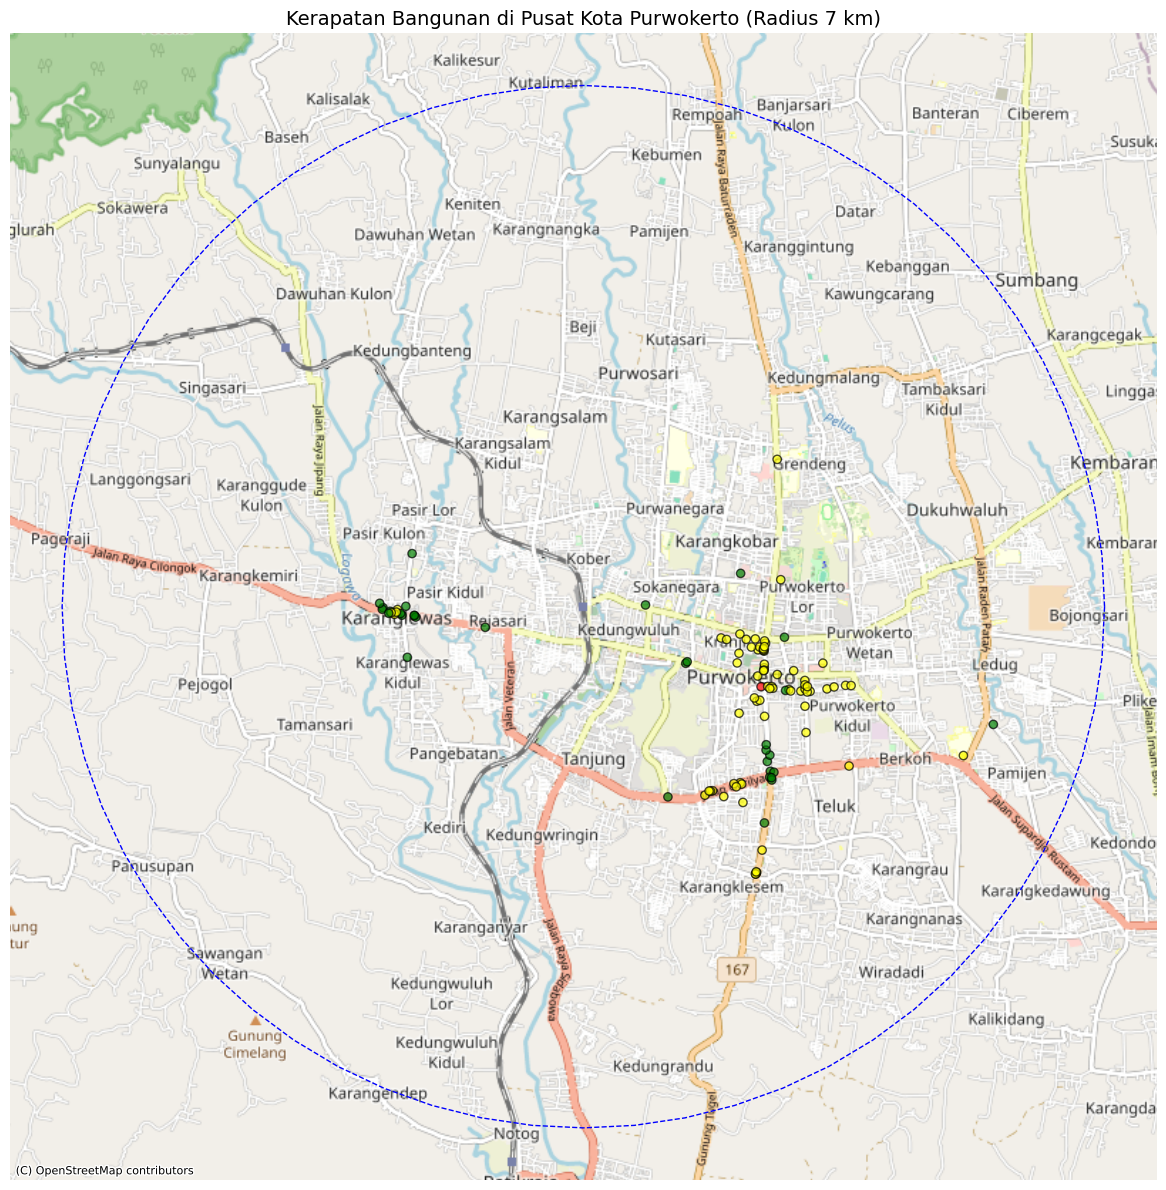

In [14]:
# Titik pusat kota Purwokerto
center_point = ox.geocode("Purwokerto, Jawa Tengah, Indonesia")
radius_m = 7000

# Konversi ke CRS meter
results_gdf_meter = results_gdf.to_crs(epsg=3857)

# Buat geometry titik pusat dalam EPSG:3857
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x_center, y_center = transformer.transform(center_point[1], center_point[0])
center_geom = Point(x_center, y_center)

# Buat lingkaran (buffer) sebagai batas tampilan kota
boundary_circle = center_geom.buffer(radius_m)

# Filter: hanya data dalam lingkaran radius 7 km dari pusat
within_city = results_gdf_meter[results_gdf_meter.geometry.within(boundary_circle)]

# Warnai berdasarkan kategori kerapatan
warna_kategori = {
    "Rendah": "green",
    "Sedang": "yellow",
    "Tinggi": "red"
}
within_city["color"] = within_city["kategori_kerapatan"].map(warna_kategori)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
within_city.plot(ax=ax, color=within_city["color"], edgecolor="black", alpha=0.7)

# Tambahkan boundary kota (opsional)
gpd.GeoSeries([boundary_circle]).plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--")

# Tambahkan basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Kerapatan Bangunan di Pusat Kota Purwokerto (Radius 7 km)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
import os

output_folder = "./output_kerapatan"
os.makedirs(output_folder, exist_ok=True)

# Ekspor GeoJSON
results_gdf.to_file(os.path.join(output_folder, "hasil_kerapatan.geojson"), driver="GeoJSON")

# Ekspor Shapefile (pastikan nama kolom <10 karakter jika error)
shp_gdf = results_gdf.rename(columns={
    "nama_bangunan": "nama_bang",
    "building_count": "bld_count",
    "building_area_m2": "bld_area",
    "buffer_area_m2": "buf_area",
    "building_density": "bld_dens",
    "kategori_kerapatan": "kategori"
})
shp_gdf.to_file(os.path.join(output_folder, "hasil_kerapatan.shp"))

# Ekspor CSV
results_gdf.drop(columns="geometry").to_csv(os.path.join(output_folder, "hasil_kerapatan.csv"), index=False)

# Ekspor Excel
results_gdf.drop(columns="geometry").to_excel(os.path.join(output_folder, "hasil_kerapatan.xlsx"), index=False)

print("✅ Semua file berhasil disimpan di folder:", output_folder)


✅ Semua file berhasil disimpan di folder: ./output_kerapatan


In [16]:
print("Kolom pada all_buildings:")
print(all_buildings.columns)

print("\nContoh data:")
print(all_buildings.head())


Kolom pada all_buildings:
Index(['geometry', 'addr:housename', 'addr:housenumber', 'addr:street',
       'building', 'name', 'designation', 'amenity', 'addr:city',
       'addr:district', 'addr:postcode', 'addr:province', 'addr:subdistrict',
       'air_conditioning', 'branch', 'email', 'name:en', 'office',
       'official_name', 'opening_hours', 'operator:type', 'website',
       'wikidata', 'wikipedia', 'museum', 'operator', 'tactile_paving',
       'tourism', 'wheelchair', 'brand', 'brand:wikidata', 'brand:wikipedia',
       'official_name:en', 'official_name:id', 'parking', 'source', 'shop',
       'building:levels', 'smoking', 'atm', 'currency:IDR', 'drive_through',
       'layer', 'railway', 'public_transport', 'denomination', 'religion',
       'brand:en', 'brand:id', 'name:id', 'phone', 'service:bicycle:repair',
       'service:bicycle:retail', 'cuisine', 'government', 'description',
       'addr:neighbourhood', 'man_made', 'organic', 'access:roof',
       'capacity:persons', 

In [23]:
datacut = pd.read_csv('output_kerapatan/hasil_kerapatan.csv')

datacut = datacut[['nama_bangunan', 'building_density', 'kategori_kerapatan']]


In [24]:
datacut.head()

nama_bangunan  building_density kategori_kerapatan
0                           Abata          0.614118             Tinggi
1                     Adi Permana          0.198119             Rendah
2  alet mas plastik - studio beau          0.000000             Rendah
3         Alfamart (deket telkom)          0.408693             Sedang
4          Alfamart Karanglewas 1          0.231976             Rendah

In [25]:
datacut.to_csv('output_kerapatan/hasil_kerapatan_terpotong.csv', index=False)
